In `Comapre intermediate results -- 2` and `Comapre intermediate results -- 3` I established that the time embeddings on local / cloud is equal.

But why are they shown as different in my overview?

In [1]:
import torch
from torch.testing import assert_close
from torch import allclose, nn, tensor
torch.set_printoptions(linewidth=200)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps'
device_dtype = torch.float16 if device == 'cuda' else torch.float32

## Load the model

In [3]:
from diffusers import StableDiffusionXLPipeline
from diffusers import EulerDiscreteScheduler
from diffusers.models.controlnetxs import ControlNetXSModel
from diffusers.pipelines.controlnet_xs.pipeline_controlnet_xs_sd_xl import StableDiffusionXLControlNetXSPipeline

In [4]:
sdxl_pipe = StableDiffusionXLPipeline.from_single_file('weights/sdxl/sd_xl_base_1.0_0.9vae.safetensors').to(device)
cnxs = ControlNetXSModel.from_pretrained('weights/cnxs').to(device)

At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...
At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...


In [5]:
cnxs.base_model = sdxl_pipe.unet

The example script of Heidelberg manually sets scale_list to 0.95

In [6]:
cnxs.scale_list = cnxs.scale_list * 0. + 0.95
assert cnxs.scale_list[0] == .95

Heidelberg uses `timestep_spacing = 'linspace'` in their scheduler, so let's do that as well

In [7]:
scheduler_cgf = dict(sdxl_pipe.scheduler.config)
scheduler_cgf['timestep_spacing'] = 'linspace'
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

# test it worked
sdxl_pipe.scheduler.set_timesteps(50)
assert sdxl_pipe.scheduler.timesteps[0]==999

# reset
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...
timestep_spacing = "leading" and timesteps=[999.      978.61224 958.2245  937.83673 917.449  ] ...
sigmas before interpolation: [0.02916753 0.04131448 0.05068044 0.05861427 0.06563709] ...
sigmas after (linear) interpolation: [14.61464691 12.93677721 11.49164976 10.24291444  9.16035419] ...
At end of `set_timesteps`:
sigmas =  tensor([14.6146, 12.9368, 11.4916, 10.2429,  9.1604]) ...
timesteps = tensor([999.0000, 978.6122, 958.2245, 937.8367, 917.4490]) ...
At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...


In [8]:
cnxs_pipe = StableDiffusionXLControlNetXSPipeline(
    vae=sdxl_pipe.vae,
    text_encoder=sdxl_pipe.text_encoder,
    text_encoder_2=sdxl_pipe.text_encoder_2,
    tokenizer=sdxl_pipe.tokenizer,
    tokenizer_2=sdxl_pipe.tokenizer_2,
    unet=sdxl_pipe.unet,
    controlnet=cnxs,
    scheduler=sdxl_pipe.scheduler,
)

___

## Re-confirm the time embs before projection are identical

In [9]:
from util import print_shapes
from util_plot import visually_compare_1d

def equal(x,y,atol=1e-4): return allclose(x.cpu(),y.cpu(),atol=atol)

Load cloud additional time embeds

In [22]:
infos = ('txt','orig_sz','crop','tgt_sz')
splits = (1280, 512, 512, 512)

In [23]:
c_vector = torch.load('intermediate_output/temb/cloud/c_vector', map_location='cpu')
uc_vector = torch.load('intermediate_output/temb/cloud/uc_vector', map_location='cpu')

emb_cloud_uc = dict(zip(infos, torch.split(uc_vector[0], splits, dim=0)))
emb_cloud_c = dict(zip(infos, torch.split(c_vector[0], splits, dim=0)))

print_shapes(*emb_cloud_uc.values())
print_shapes(*emb_cloud_c.values())

[1280], [512], [512], [512]
[1280], [512], [512], [512]


Load local additional time embeds

In [24]:
emb_l_add_embeds = torch.load('intermediate_output/temb/local/add_embeds', map_location='cpu')

emb_local_uc = dict(zip(infos, torch.split(emb_l_add_embeds[0], splits, dim=0)))
emb_local_c = dict(zip(infos, torch.split(emb_l_add_embeds[1], splits, dim=0)))

print_shapes(*emb_local_uc.values())
print_shapes(*emb_local_c.values())

[1280], [512], [512], [512]
[1280], [512], [512], [512]


In [48]:
for i in infos:
    assert equal(emb_cloud_uc[i], emb_local_uc[i], atol=1e-2)
    assert equal(emb_cloud_c[i],  emb_local_c[i], atol=1e-2)

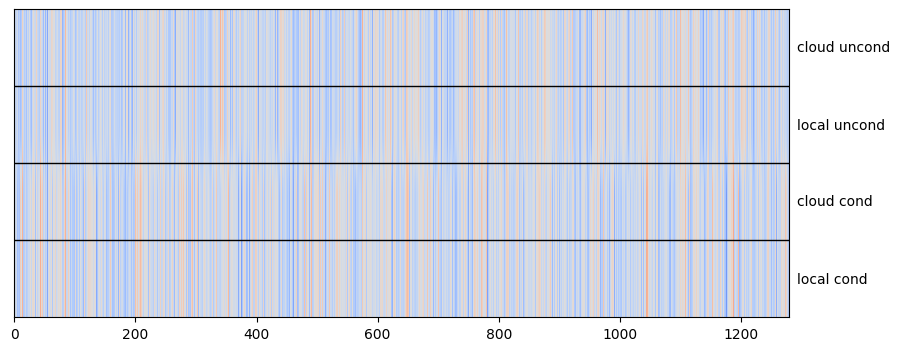

In [53]:
visually_compare_1d(
    (emb_cloud_uc['txt'], emb_local_uc['txt'],emb_cloud_c['txt'], emb_local_c['txt']),
    ('cloud uncond', 'local uncond','cloud cond', 'local cond')
)

## Load intermediate outputs of full model

These were computed on the cloud with Heidelberg code

In [30]:
from util_inspect import load_intermediate_outputs, print_metadata, compare_intermediate_results

In [31]:
model_outp_cloud = load_intermediate_outputs('intermediate_output/cloud_debug_log.pkl')
model_outp_local = load_intermediate_outputs('intermediate_output/local_debug_log.pkl')
len(model_outp_cloud),len(model_outp_local)

(72, 72)

In [35]:
model_outp_cloud[1].shape, model_outp_local[1].shape

([2, 1280], [2, 1280])

In [55]:
temb_cloud_uc, temb_cloud_c = model_outp_cloud[1].t
temb_local_uc, temb_local_c = model_outp_local[1].t
print_shapes(temb_cloud_uc, temb_cloud_c, temb_local_uc, temb_local_c)

[1280], [1280], [1280], [1280]


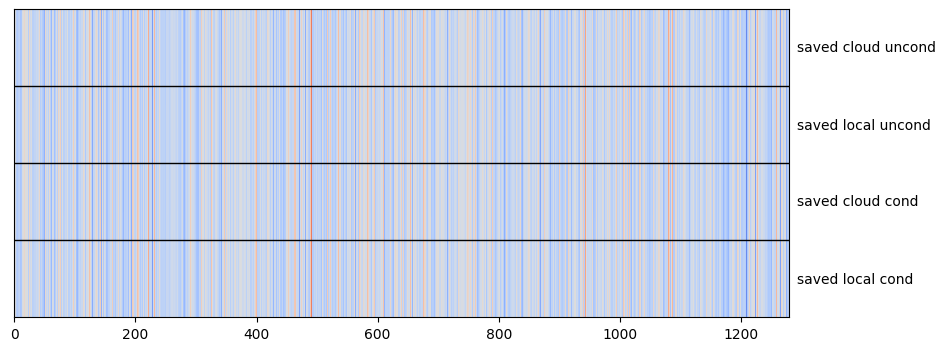

In [56]:
visually_compare_1d(
    (
        temb_cloud_uc,temb_local_c,
        temb_cloud_c,temb_local_uc,
    ),
    (
        'saved cloud uncond', 'saved local uncond',
        'saved cloud cond', 'saved local cond',
    )
)

**This can't be.** Condtional and unconditional embeddings should be different

In [57]:
equal(temb_local_c, temb_local_uc, atol=1e-2)

False

In [58]:
equal(temb_local_c, temb_local_uc, atol=1e-1)

False

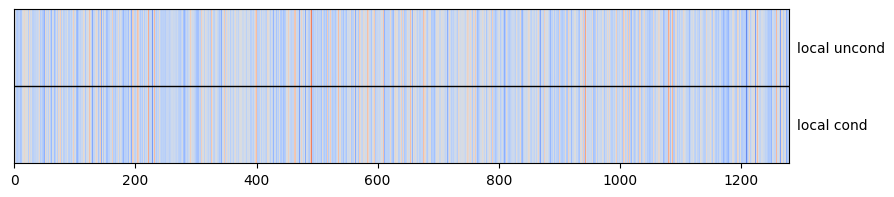

In [60]:
visually_compare_1d((temb_local_uc, temb_local_c), ('local uncond', 'local cond'))

These should be different!

In [61]:
temb_local_uc[:10], temb_local_c[:10]

(tensor([ 1.4959, -3.6011,  1.8189, -1.6592, -1.5132, -2.1749, -1.6586, -1.7922,  0.0885, -2.2889]),
 tensor([ 1.3859, -3.5991,  1.8941, -1.6574, -1.5342, -2.2058, -1.7063, -1.7391,  0.0161, -2.2524]))

I would have expected `temb_local_uc` and `temb_local_c` to be very different

Same for cloud versions:

In [63]:
temb_cloud_uc[:10], temb_cloud_c[:10]

(tensor([ 1.5199, -3.6599,  1.8496, -1.6871, -1.5362, -2.2114, -1.6819, -1.8184,  0.0893, -2.3246]),
 tensor([ 1.4099, -3.6581,  1.9248, -1.6852, -1.5572, -2.2422, -1.7296, -1.7654,  0.0171, -2.2881]))

___

Let's reproduce `temb_local_uc` and `temb_local_c`

Remember: `temb = temb + self.base_model.add_embedding(add_embeds)`, where `temb` is the pure time embedding

In [88]:
t = tensor([999.])
t

tensor([999.])

In [89]:
from diffusers.models.embeddings import get_timestep_embedding

In [109]:
temb_pure_time_1 = get_timestep_embedding(t, 320, flip_sin_to_cos=True, downscale_freq_shift=0)
temb_pure_time_1.shape

torch.Size([1, 320])

In [110]:
temb_pure_time_1[0,:10]

tensor([ 0.9996,  0.8027, -0.2781,  0.1768, -0.2780,  0.1252, -0.9289, -0.0870, -0.4233, -0.2622])

Because `learn_embedding=True`, we use a combindation of control's and base's time projection (weighting determined by `cnxs.config.control_scale`)

In [111]:
cnxs.config.control_scale

0.95

In [112]:
time_projection_ctrl = cnxs.control_model.time_embedding
time_projection_base = cnxs.base_model.time_embedding

print(time_projection_ctrl)
print(time_projection_base)

TimestepEmbedding(
  (linear_1): Linear(in_features=320, out_features=1280, bias=True)
  (act): SiLU()
  (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
)
TimestepEmbedding(
  (linear_1): LoRACompatibleLinear(in_features=320, out_features=1280, bias=True)
  (act): SiLU()
  (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
)


**Q:** The `in_features`, ie the time emb has shape 320, but on cloud it is 256!

**A:** No, the `in_features` are the dimension of the timestep embedding. The timestep embedding for (i) time and (ii) additional info (orig size, crop, target size) are different. They're `320` and `256` respectively.

Here's how the timestep embedding for time is computed on cloud: `t_emb = timestep_embedding(timesteps, self.model_channels, repeat_only=False)` with `self.model_channels=320`

In [113]:
def apply_time_projection(temb, alpha): return time_projection_ctrl(temb) * alpha**0.3 + time_projection_base(temb) * (1-alpha**0.3)

In [119]:
temb_pure_time_2 = apply_time_projection(temb_pure_time_1.to(device), 0.95).cpu().detach()
temb_pure_time_2.shape

torch.Size([1, 1280])

In [120]:
temb_pure_time_2[:10]

tensor([[ 1.3571, -3.6848,  1.9868,  ..., -0.7487, -1.2921, -1.4140]])

Now, let's project the additional time info

In [121]:
add_time_projection = cnxs.base_model.add_embedding
add_time_projection

TimestepEmbedding(
  (linear_1): LoRACompatibleLinear(in_features=2816, out_features=1280, bias=True)
  (act): SiLU()
  (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
)

In [122]:
emb_l_add_embeds.shape

torch.Size([2, 2816])

In [127]:
temb_only_additional = add_time_projection(emb_l_add_embeds.to(device)).cpu().detach()
temb_only_additional.shape

torch.Size([2, 1280])

In [129]:
temb_final = temb_pure_time_2 + temb_only_additional
temb_final.shape

torch.Size([2, 1280])

In [130]:
temb_local_uc_reproduced, temb_local_c_reproduced = temb_final
print_shapes(temb_local_uc_reproduced, temb_local_c_reproduced)

[1280], [1280]


In [139]:
equal(temb_local_uc_reproduced,temb_local_uc,atol=1e-5), equal(temb_local_c_reproduced,temb_local_c,atol=1e-4)

(True, True)

___

In [46]:
compare_intermediate_results(model_outp_cloud, model_outp_local, n=20, prec=5, compare_prec=3)

-  | cloud               | local               | equal name? | equal shape? | equal values? | mean abs Δ
   |                     |                     |             |              |    prec=3     |     prec=5
--------------------------------------------------------------------------------------------------------
0  | prep   x            | prep   x            |      y      |      y       |       y       |    0.00000
1  | prep   temb         | prep   temb         |      y      |      y       |       n       |    0.02456
2  | prep   context      | prep   context      |      y      |      y       |       n       |    0.00053
3  | prep   raw hint     | prep   raw hint     |      y      |      y       |       y       |    0.00000
4  | prep   guided_hint  | prep   guided_hint  |      y      |      y       |       n       |    0.00009
--------------------------------------------------------------------------------------------------------
5  | enc    h_base       | enc    h_base       |      y

## Load intermediate outputs of 1st resnet

In [ ]:
resnet_outp_cloud = load_intermediate_outputs('intermediate_output/cloud_resnet.pkl')
resnet_outp_local = load_intermediate_outputs('intermediate_output/local_resnet.pkl')
len(resnet_outp_cloud),len(resnet_outp_local)

## Compare!

In [ ]:
from diffusers.models.controlnetxs import to_sub_blocks
my_subs = to_sub_blocks(cnxs.base_model.down_blocks[0])
assert len(my_subs)==3
first_base_enc_subblock = my_subs[0] # that's the local module (I can't access cloud modules)

In [ ]:
prev_h_base_cloud = model_outp_cloud[8].t
prev_h_base_local = model_outp_local[8].t

temb_cloud = model_outp_cloud[1].t
temb_local = model_outp_local[1].t

current_h_base_cloud = model_outp_cloud[10].t
current_h_base_local = model_outp_local[10].t

In [ ]:
model_outp_cloud[1].msg, model_outp_cloud[1].shape

In [ ]:
temb_cloud[0].shape,temb_cloud[1].shape

In [ ]:
allclose(temb_cloud[0], temb_cloud[1])

**These should be equal! Why are they not?** 😤🤔

**Edit:** To the time embedding, information for `crop`, `original_size` and `target_size` is added. 

In [ ]:
print_metadata(resnet_outp_cloud)

In [ ]:
print_metadata(resnet_outp_local)

In [ ]:
# map cloud steps to local steps, because in cloud some steps are bundled
c2l = dict(enumerate((0,1,2,5,7,8,12,13)))

l2c = {l:c for c,l in c2l.items()}
l2c.update({l: None for l in range(len(resnet_outp_local)) if l not in l2c.keys()})

In [ ]:
from torch import tensor
from util_inspect import divider, fmt_bool, have_same_shapes, have_same_values, broadcast

def compare_intermediate_results():
    step_map = (0,1,2,5,7,8,12,13)
    
    l,c,es,ev,d = 'local','cloud','equal shape?','equal values?','mean abs Δ'
    print(f'{l:<36} | {c:<48} | {es:<12} | {ev:<13} | {d:<10}')
    c,l,es,ev,d = '','','','prec=2',''
    print(f'{l:<36} | {c:<48} | {es:<12} | {ev:^13} | {d:<10}')
    divider(l=36+3+48+3+12+3+13+3+10)
    for li in range(len(resnet_outp_local)):
        l=resnet_outp_local[li]
        print(f'{li:>2} {l.stage:<14} {l.msg:<18} | ',end='')

        if l2c[li] is not None:
            ci = l2c[li]
            c=resnet_outp_cloud[ci]
        
            print(f'{ci:>2} {c.stage:<14} {c.msg:<30} | ',end='')
            
            eq_shape = have_same_shapes(c,l,do_print=False,assert_names_match=False)
            if hasattr(c.t, 'shape'):
                eq_vals = have_same_values(c,l,do_print=False,prec=2,assert_names_match=False)   
                ct,lt = broadcast(c.t,l.t)
                mae = (ct-lt).abs().mean()
            else:
                eq_vals = c.t==l.t
                mae = (tensor(c.t)-tensor(l.t)).abs().mean()
                
            print(fmt_bool(eq_shape, '^12')+' | '+fmt_bool(eq_vals, '^13')+' | ', end='')
            print(f'{mae:>10.5f}',end='')
        
        print()

In [ ]:
compare_intermediate_results()

Something is wrong with the time information or the time projection

## Run 1 step locally

In [9]:
import torch
import random
import numpy as np
import cv2
from diffusers.utils import load_image
import matplotlib.pyplot as plt

class CannyDetector:
    def __call__(self, img, low_threshold, high_threshold):
        return cv2.Canny(img, low_threshold, high_threshold)

def get_canny_edges(image, threshold=(100, 250)):
    image = np.array(image).astype(np.uint8)
    edges = CannyDetector()(image, *threshold)  # original sized greyscale edges
    edges = edges / 255.
    return edges

def seed_everything(seed):
    # paper used deprecated `seed_everything` from pytorch lightning
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)

RANDOM_SEED_IN_PAPER = 1999158951

In [10]:
latents_sdxl_cloud = torch.load('latents_cloud_no_control.pth', map_location=torch.device(device))
rand_from_cloud = latents_sdxl_cloud[0] / 14.6146

In [11]:
prompt = 'cinematic, shoe in the streets, made from meat, photorealistic shoe, highly detailed'
neg_prompt = 'lowres, bad anatomy, worst quality, low quality'

image = load_image('input_images/shoe_cloud.png')
edges = get_canny_edges(image)

edges_tensor = torch.tensor(edges)
three_edges = torch.stack((edges_tensor,edges_tensor,edges_tensor))
three_edges.shape

torch.Size([3, 768, 768])

In [12]:
cnxs_pipe.controlnet.DEBUG_LOG_by_Umer = True
cnxs_pipe.controlnet.DEBUG_LOG_by_Umer_file = 'intermediate_output/local_debug_log.pkl'
cnxs_pipe.controlnet.DEBUG_LOG_by_Umer

True

In [13]:
seed_everything(RANDOM_SEED_IN_PAPER)
cnxs_pipe(prompt, negative_prompt=neg_prompt,image=three_edges, latents=rand_from_cloud)

timestep_spacing = "leading" and timesteps=[999.      978.61224 958.2245  937.83673 917.449  ] ...
sigmas before interpolation: [0.02916753 0.04131448 0.05068044 0.05861427 0.06563709] ...
sigmas after (linear) interpolation: [14.61464691 12.93677721 11.49164976 10.24291444  9.16035419] ...
At end of `set_timesteps`:
sigmas =  tensor([14.6146, 12.9368, 11.4916, 10.2429,  9.1604], device='mps:0') ...
timesteps = tensor([999.0000, 978.6122, 958.2245, 937.8367, 917.4490], device='mps:0') ...
Passed in latents:  tensor([ 1.3333,  0.5155,  0.4647, -0.5344,  1.0102], device='mps:0')
initial_unscaled_latents:  tensor([ 1.3333,  0.5155,  0.4647, -0.5344,  1.0102], device='mps:0')
latents:  tensor([19.4858,  7.5339,  6.7910, -7.8098, 14.7639], device='mps:0')
add_time_ids = tensor([[768., 768.,   0.,   0., 768., 768.],
        [768., 768.,   0.,   0., 768., 768.]], device='mps:0')


  0%|          | 0/50 [00:00<?, ?it/s]

time_ids: tensor([[768., 768.,   0.,   0., 768., 768.],
        [768., 768.,   0.,   0., 768., 768.]], device='mps:0')
timesteps = tensor(999., device='mps:0')
timesteps = tensor([999.], device='mps:0')
t_emb.shape = [1, 320]
learn_embedding = True
t_emb.shape = [1, 1280]


/Users/umer/Documents/GitHub/diffusers/diffusers/src/diffusers/models/controlnetxs.py:311: FutureWarning: Accessing config attribute `control_scale` directly via 'ControlNetXSModel' object attribute is deprecated. Please access 'control_scale' over 'ControlNetXSModel's config object instead, e.g. 'unet.config.control_scale'.
  temb = self.control_model.time_embedding(t_emb) * self.control_scale ** 0.3 + self.base_model.time_embedding(t_emb) * (1 - self.control_scale ** 0.3)


RuntimeError: Hey kid, wanna analyze time emb?		They're in intermediate_output/temb/local/

In [14]:
%debug

> /Users/umer/Documents/GitHub/diffusers/diffusers/src/diffusers/models/controlnetxs.py(348)forward()
    346             torch.save(aug_emb, 'intermediate_output/temb/local/aug_embeds')
    347 
--> 348             raise RuntimeError("Hey kid, wanna analyze time emb?\t\tThey're in intermediate_output/temb/local/")
    349 
    350         elif self.config.addition_embed_type == "image":



ipdb>  info = [768,768,0,0,768,768]
ipdb>  info = tensor([info,info])


*** NameError: name 'tensor' is not defined


ipdb>  info = torch.tensor([info,info])
ipdb>  info==time_ids


*** RuntimeError: Expected all tensors to be on the same device, but found at least two devices, mps:0 and cpu!


ipdb>  time_ids.cpu()==info


tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True]])


ipdb>  my_time_embeds = self.base_model.add_time_proj(time_ids.flatten()).reshape((2, -1))
ipdb>  my_time_embeds==time_embeds


tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='mps:0')


ipdb>  emb_l_time_embeds = torch.load('intermediate_output/temb/local/time_embeds', map_location='cpu')
ipdb>  emb_l_time_embeds==time_embeds


*** RuntimeError: Expected all tensors to be on the same device, but found at least two devices, mps:0 and cpu!


ipdb>  emb_l_time_embeds.cpu()==time_embeds


*** RuntimeError: Expected all tensors to be on the same device, but found at least two devices, mps:0 and cpu!


ipdb>  emb_l_time_embeds.cpu()==time_embeds.cpu()


tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])


ipdb>  (emb_l_time_embeds.cpu()==time_embeds.cpu()).all()


tensor(True)


ipdb>  timestep = self.base_model.add_time_proj
ipdb>  timestep.num_channels, timestep.flip_sin_to_cos,  timestep.downscale_freq_shift 


(256, True, 0)


ipdb>  c


In [16]:
my_timestep = cnxs.base_model.add_time_proj
my_timestep.num_channels, my_timestep.flip_sin_to_cos, my_timestep.downscale_freq_shift 

(256, True, 0)

___

## Look at time info in 1st resnet

In [ ]:
local_time_linear_in_first_resnet = cnxs.base_model.down_blocks[0].resnets[0].time_emb_proj.cpu()

In [ ]:
cloud_time_linear_in_first_resnet = nn.Linear(
    local_time_linear_in_first_resnet.in_features,
    local_time_linear_in_first_resnet.out_features
)
cloud_time_linear_in_first_resnet.load_state_dict(torch.load('time_linear_in_first_resnet.pth',map_location=torch.device('cpu')))

In [ ]:
local_time_linear_in_first_resnet.parameters()==cloud_time_linear_in_first_resnet.parameters()

In [ ]:
c_w, c_b = cloud_time_linear_in_first_resnet.parameters()
l_w, l_b = local_time_linear_in_first_resnet.parameters()

allclose(c_w,l_w), allclose(c_b,l_b)

In [ ]:
c_temb, l_temb = model_outp_cloud[1].t,model_outp_local[1].t
c_temb.shape, l_temb.shape

In [ ]:
mae = torch.nn.functional.l1_loss
silu = nn.SiLU()

In [ ]:
mae(c_temb,l_temb)

In [ ]:
mae(silu(c_temb), silu(l_temb))

In [ ]:
c_temb_projected = cloud_time_linear_in_first_resnet(silu(c_temb))
l_temb_projected = local_time_linear_in_first_resnet(silu(l_temb))

In [ ]:
print_shapes(c_temb_projected, l_temb_projected)

In [ ]:
mae(c_temb_projected, l_temb_projected)

In [ ]:
c_temb_projected_saved = resnet_outp_cloud[4].t
l_temb_projected_saved = resnet_outp_local[7].t

In [ ]:
print_shapes(c_temb_projected_saved, l_temb_projected_saved)

In [ ]:
mae(c_temb_projected_saved, l_temb_projected_saved)

In [ ]:
mae(c_temb_projected_saved[:,:,None,None], l_temb_projected_saved)

In [ ]:
print_shapes(c_temb_projected, l_temb_projected)
print_shapes(c_temb_projected_saved, l_temb_projected_saved)

In [ ]:
c_h_before_time_add_saved = resnet_outp_cloud[3].t
l_h_before_time_add_saved = resnet_outp_local[5].t

print_shapes(c_h_before_time_add_saved, l_h_before_time_add_saved)